In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
num_skipped = 0
for project in ("dipsy", "lala", "po", "tinky"):
    folder_path = os.path.join("project", project)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
batch_size = 16
img_height = 240
img_width = 240

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "project",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 272 files belonging to 4 classes.
Using 218 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "project",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 272 files belonging to 4 classes.
Using 54 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['dipsy', 'lala', 'po', 'tinky']


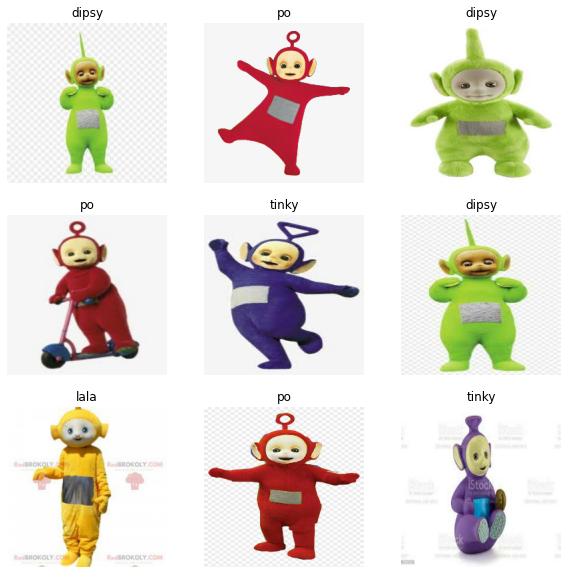

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 240, 240, 3)
(16,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.5),
    layers.RandomContrast(0.5),
    layers.RandomBrightness(0.4, value_range=(0, 255))
  ]
)

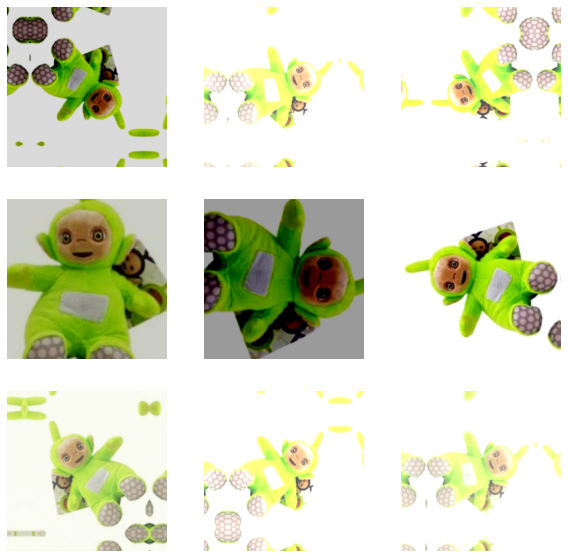

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, activation='relu', kernel_initializer="he_normal"),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer="he_normal"),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer="he_normal"),
  layers.MaxPooling2D((3, 3)),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu', kernel_initializer="he_normal"),
  layers.Dense(num_classes, kernel_initializer="glorot_normal")
])

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 240, 240, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 32)       0         
 2D)                                                  

In [15]:
epochs=11
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/11
14/14 [==============================] - 6s 352ms/step - loss: 1.8146 - accuracy: 0.3440 - val_loss: 1.1120 - val_accuracy: 0.5556
Epoch 2/11
14/14 [==============================] - 5s 337ms/step - loss: 0.7954 - accuracy: 0.7064 - val_loss: 0.4772 - val_accuracy: 0.7407
Epoch 3/11
14/14 [==============================] - 5s 342ms/step - loss: 0.4545 - accuracy: 0.8165 - val_loss: 0.2838 - val_accuracy: 0.8519
Epoch 4/11
14/14 [==============================] - 5s 332ms/step - loss: 0.3963 - accuracy: 0.8578 - val_loss: 0.1537 - val_accuracy: 0.9815
Epoch 5/11
14/14 [==============================] - 5s 339ms/step - loss: 0.2505 - accuracy: 0.9220 - val_loss: 0.4245 - val_accuracy: 0.9630
Epoch 6/11
14/14 [==============================] - 5s 331ms/step - loss: 0.2660 - accuracy: 0.9220 - val_loss: 0.0760 - val_accuracy: 0.9815
Epoch 7/11
14/14 [==============================] - 5s 329ms/step - loss: 0.2233 - accuracy: 0.9174 - val_loss: 0.1145 - val_accuracy: 0.9815
Epoch 

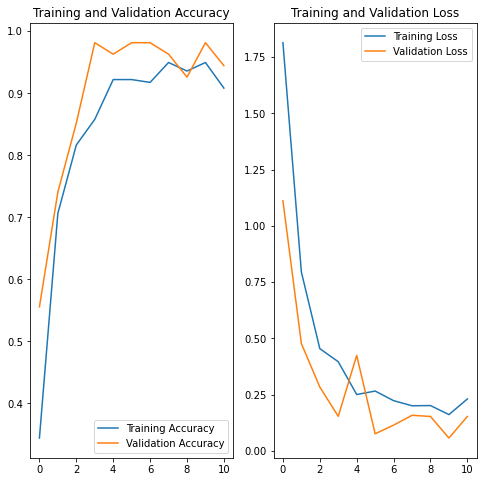

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [22]:
img = keras.preprocessing.image.load_img(
    "T6.jpg", target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This is most likely '{}' with a confidence of {:.2f} percent!"
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 23ms/step
This is most likely 'tinky' with a confidence of 100.00 percent!
